In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json
from pathlib import Path

cfg_path = Path("/content/drive/MyDrive/UrbanSimAI_Chicago/urbansim_config.json")
cfg = json.loads(cfg_path.read_text())

PROJECT_ROOT = Path(cfg["PROJECT_ROOT"])
RAW_DIR = Path(cfg["RAW_DIR"])
PROC_DIR = Path(cfg["PROC_DIR"])
REPORT_DIR = Path(cfg["REPORT_DIR"])

# create extra folders for this notebook
MODELS_DIR = PROJECT_ROOT / "models"
FIG_DIR = REPORT_DIR / "figures"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROC_DIR:", PROC_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("FIG_DIR:", FIG_DIR)

PROJECT_ROOT: /content/drive/MyDrive/UrbanSimAI_Chicago
PROC_DIR: /content/drive/MyDrive/UrbanSimAI_Chicago/data_processed
MODELS_DIR: /content/drive/MyDrive/UrbanSimAI_Chicago/models
FIG_DIR: /content/drive/MyDrive/UrbanSimAI_Chicago/reports/figures


In [ ]:
!pip -q install scikit-learn catboost xgboost holidays joblib matplotlib pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import joblib
import holidays

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

SEED = 42
np.random.seed(SEED)

def stamp():
    return datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S UTC")

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("✅ Ready:", stamp())


✅ Ready: 2025-12-14 04:34:16 UTC


In [ ]:
traffic_zip_hourly_path = PROC_DIR / "traffic_zip_hourly.parquet"
zillow_path = PROC_DIR / "zillow_zhvi_chicago_zip_long.parquet"
cta_path = PROC_DIR / "cta_stops_by_zip.parquet"

assert traffic_zip_hourly_path.exists(), f"Missing: {traffic_zip_hourly_path}"
assert zillow_path.exists(), f"Missing: {zillow_path}"
assert cta_path.exists(), f"Missing: {cta_path}"

traffic = pd.read_parquet(traffic_zip_hourly_path)
zillow = pd.read_parquet(zillow_path)
cta = pd.read_parquet(cta_path)

print("traffic:", traffic.shape, traffic.columns.tolist())
print("zillow:", zillow.shape, zillow.columns.tolist())
print("cta:", cta.shape, cta.columns.tolist())

traffic["zip"] = traffic["zip"].astype(str).str.zfill(5)
cta["zip"] = cta["zip"].astype(str).str.zfill(5)
zillow["zip"] = zillow["zip"].astype(str).str.zfill(5)

traffic["hour_ts"] = pd.to_datetime(traffic["hour_ts"])
zillow["date"] = pd.to_datetime(zillow["date"])

traffic: (121068, 4) ['zip', 'hour_ts', 'avg_speed', 'n_obs']
zillow: (17980, 3) ['zip', 'date', 'zhvi']
cta: (59, 2) ['zip', 'cta_stop_count']


In [ ]:
# CTA stops is static (one value per zip)
df = traffic.merge(cta, on="zip", how="left")
df["cta_stop_count"] = df["cta_stop_count"].fillna(0)

# Ensure sorting + consistent datetime dtypes
df = df.sort_values(["zip", "hour_ts"]).copy()
z_sorted = zillow.sort_values(["zip", "date"]).copy()

# Create merge key (force datetime64[ns])
df["date_key"] = pd.to_datetime(df["hour_ts"].dt.floor("D")).astype("datetime64[ns]")
z_sorted["date_key"] = pd.to_datetime(z_sorted["date"].dt.floor("D")).astype("datetime64[ns]")

out = []
for zc, g in df.groupby("zip", sort=False):
    gz = z_sorted[z_sorted["zip"] == zc][["date_key", "zhvi"]].sort_values("date_key")
    gg = g.sort_values("date_key")

    if len(gz) == 0:
        gg["zhvi"] = np.nan
    else:
        gg = pd.merge_asof(
            gg,
            gz,
            on="date_key",
            direction="backward",
            allow_exact_matches=True
        )
    out.append(gg)

df = pd.concat(out, ignore_index=True)

# Fill any missing zhvi
df["zhvi"] = df["zhvi"].fillna(df["zhvi"].median())

print("✅ After merges:", df.shape)
df.head()

✅ After merges: (121068, 7)


,zip,hour_ts,avg_speed,n_obs,cta_stop_count,date_key,zhvi
0,60601,2025-09-15 04:00:00,2.104167,48,43,2025-09-15,353242.219186
1,60601,2025-09-15 23:00:00,7.364583,96,43,2025-09-15,353242.219186
2,60601,2025-09-15 22:00:00,8.520833,96,43,2025-09-15,353242.219186
3,60601,2025-09-15 21:00:00,14.354167,96,43,2025-09-15,353242.219186
4,60601,2025-09-15 20:00:00,9.729167,96,43,2025-09-15,353242.219186


In [ ]:
us_holidays = holidays.US(state="IL")  # Illinois holidays

df["hour"] = df["hour_ts"].dt.hour
df["dow"] = df["hour_ts"].dt.dayofweek  # Mon=0
df["month"] = df["hour_ts"].dt.month
df["weekofyear"] = df["hour_ts"].dt.isocalendar().week.astype(int)

df["is_weekend"] = (df["dow"] >= 5).astype(int)
df["is_holiday"] = df["hour_ts"].dt.date.map(lambda d: 1 if d in us_holidays else 0)

print("✅ Time features added")

✅ Time features added


In [ ]:
df = df.sort_values(["zip", "hour_ts"]).copy()

# target
TARGET = "avg_speed"

# lags
for lag in [1, 2, 3, 24, 168]:
    df[f"lag_{lag}"] = df.groupby("zip")[TARGET].shift(lag)

# rolling windows (use past only)
df["roll_mean_3"] = df.groupby("zip")[TARGET].shift(1).rolling(3).mean().reset_index(level=0, drop=True)
df["roll_mean_6"] = df.groupby("zip")[TARGET].shift(1).rolling(6).mean().reset_index(level=0, drop=True)
df["roll_mean_24"] = df.groupby("zip")[TARGET].shift(1).rolling(24).mean().reset_index(level=0, drop=True)
df["roll_std_24"] = df.groupby("zip")[TARGET].shift(1).rolling(24).std().reset_index(level=0, drop=True)

# keep only rows with lags available
feature_cols = [
    "zip", "cta_stop_count", "zhvi",
    "hour", "dow", "month", "weekofyear", "is_weekend", "is_holiday",
    "lag_1", "lag_2", "lag_3", "lag_24", "lag_168",
    "roll_mean_3", "roll_mean_6", "roll_mean_24", "roll_std_24"
]

df_model = df.dropna(subset=["lag_1", "lag_24", "roll_mean_24"]).copy()
df_model = df_model.dropna(subset=[TARGET]).copy()

print("✅ df_model:", df_model.shape)
print("Min/Max hour_ts:", df_model["hour_ts"].min(), "→", df_model["hour_ts"].max())
df_model[["zip","hour_ts",TARGET] + [c for c in feature_cols if c.startswith("lag_")][:3]].head()

✅ df_model: (119472, 22)
Min/Max hour_ts: 2025-09-16 04:00:00 → 2025-12-12 23:00:00


,zip,hour_ts,avg_speed,lag_1,lag_2,lag_3
38,60601,2025-09-16 04:00:00,5.203125,4.425000,2.770833,5.010417
43,60601,2025-09-16 05:00:00,10.650000,5.203125,4.425000,2.770833
40,60601,2025-09-16 06:00:00,15.887500,10.650000,5.203125,4.425000
32,60601,2025-09-16 07:00:00,15.541667,15.887500,10.650000,5.203125
41,60601,2025-09-16 08:00:00,16.479167,15.541667,15.887500,10.650000


In [ ]:
df_model = df_model.sort_values("hour_ts").copy()

max_ts = df_model["hour_ts"].max()
test_start = max_ts - timedelta(days=14)
val_start  = max_ts - timedelta(days=28)

train_df = df_model[df_model["hour_ts"] < val_start].copy()
val_df   = df_model[(df_model["hour_ts"] >= val_start) & (df_model["hour_ts"] < test_start)].copy()
test_df  = df_model[df_model["hour_ts"] >= test_start].copy()

print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)
print("Val range:", val_df["hour_ts"].min(), "→", val_df["hour_ts"].max())
print("Test range:", test_df["hour_ts"].min(), "→", test_df["hour_ts"].max())

Train: (81168, 22) | Val: (19152, 22) | Test: (19152, 22)
Val range: 2025-11-14 23:00:00 → 2025-11-28 22:00:00
Test range: 2025-11-28 23:00:00 → 2025-12-12 23:00:00


In [ ]:
def eval_preds(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r = rmse(y_true, y_pred)
    print(f"{name:12s} | MAE={mae:.3f} | RMSE={r:.3f}")
    return {"model": name, "mae": float(mae), "rmse": float(r)}

baseline_results = []
baseline_results.append(eval_preds("Lag1",  val_df[TARGET], val_df["lag_1"]))
baseline_results.append(eval_preds("Lag24", val_df[TARGET], val_df["lag_24"]))
baseline_results

Lag1         | MAE=2.243 | RMSE=3.280
Lag24        | MAE=2.229 | RMSE=3.505


[{'model': 'Lag1', 'mae': 2.2428502855457357, 'rmse': 3.2797070785175717},
 {'model': 'Lag24', 'mae': 2.2287786119802644, 'rmse': 3.505114548348905}]

In [ ]:
X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[TARGET].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[TARGET].copy()

cat_features = ["zip"]  # CatBoost handles it directly
print("✅ Feature count:", X_train.shape[1], "| cat_features:", cat_features)

✅ Feature count: 18 | cat_features: ['zip']


In [ ]:
cb = CatBoostRegressor(
    loss_function="MAE",
    iterations=500,
    learning_rate=0.08,
    depth=8,
    random_seed=SEED,
    eval_metric="MAE",
    verbose=100
)

cb.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=50
)

val_pred_cb = cb.predict(X_val)
test_pred_cb = cb.predict(X_test)

cb_val = eval_preds("CatBoost", y_val, val_pred_cb)
cb_test = eval_preds("CatBoost(TEST)", y_test, test_pred_cb)

0:	learn: 5.4801961	test: 5.5880146	best: 5.5880146 (0)	total: 393ms	remaining: 3m 15s
100:	learn: 1.2445252	test: 1.3409931	best: 1.3409931 (100)	total: 10.5s	remaining: 41.5s
200:	learn: 1.1444725	test: 1.2849210	best: 1.2849210 (200)	total: 20.2s	remaining: 30.1s
300:	learn: 1.0860013	test: 1.2615690	best: 1.2615690 (300)	total: 27s	remaining: 17.9s
400:	learn: 1.0479908	test: 1.2500691	best: 1.2500691 (400)	total: 35.7s	remaining: 8.82s
499:	learn: 1.0182802	test: 1.2438503	best: 1.2438503 (499)	total: 43.2s	remaining: 0us

bestTest = 1.243850335
bestIteration = 499

CatBoost     | MAE=1.244 | RMSE=1.865
CatBoost(TEST) | MAE=1.220 | RMSE=1.711


In [ ]:
def one_hot(dfX):
    return pd.get_dummies(dfX, columns=["zip"], drop_first=False)

X_train_oh = one_hot(X_train)
X_val_oh   = one_hot(X_val).reindex(columns=X_train_oh.columns, fill_value=0)
X_test_oh  = one_hot(X_test).reindex(columns=X_train_oh.columns, fill_value=0)

xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    tree_method="hist"
)

xgb.fit(
    X_train_oh, y_train,
    eval_set=[(X_val_oh, y_val)],
    verbose=200
)

val_pred_xgb = xgb.predict(X_val_oh)
test_pred_xgb = xgb.predict(X_test_oh)

xgb_val = eval_preds("XGBoost", y_val, val_pred_xgb)
xgb_test = eval_preds("XGBoost(TEST)", y_test, test_pred_xgb)

[0]	validation_0-rmse:7.29504
[200]	validation_0-rmse:1.85993
[400]	validation_0-rmse:1.85766
[600]	validation_0-rmse:1.85270
[800]	validation_0-rmse:1.84844
[1000]	validation_0-rmse:1.84758
[1199]	validation_0-rmse:1.84451
XGBoost      | MAE=1.222 | RMSE=1.845
XGBoost(TEST) | MAE=1.181 | RMSE=1.666


In [ ]:
results = pd.DataFrame([cb_val, xgb_val] + baseline_results).sort_values("mae")
results

,model,mae,rmse
1,XGBoost,1.222236,1.844512
0,CatBoost,1.243851,1.865281
3,Lag24,2.228779,3.505115
2,Lag1,2.242850,3.279707


In [ ]:
trainval_df = pd.concat([train_df, val_df], ignore_index=True)

X_trainval = trainval_df[feature_cols].copy()
y_trainval = trainval_df[TARGET].copy()

best_name = results.iloc[0]["model"]
print("✅ Best model:", best_name)

model_path = MODELS_DIR / "best_speed_model.pkl"
meta_path = MODELS_DIR / "best_speed_model_meta.json"

if best_name == "CatBoost":
    best_model = CatBoostRegressor(
        loss_function="MAE",
        iterations=int(cb.tree_count_ * 1.2) if hasattr(cb, "tree_count_") else 600,
        learning_rate=0.08,
        depth=8,
        random_seed=SEED,
        verbose=100
    )
    best_model.fit(X_trainval, y_trainval, cat_features=cat_features)
    final_pred = best_model.predict(X_test)
else:
    X_trainval_oh = one_hot(X_trainval)
    X_test_oh2 = one_hot(X_test).reindex(columns=X_trainval_oh.columns, fill_value=0)

    best_model = XGBRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        tree_method="hist"
    )
    best_model.fit(X_trainval_oh, y_trainval, verbose=200)
    final_pred = best_model.predict(X_test_oh2)

final_mae = mean_absolute_error(y_test, final_pred)
final_rmse = rmse(y_test, final_pred)

print("✅ FINAL TEST:", "MAE=", round(final_mae, 3), "| RMSE=", round(final_rmse, 3))

# save model
joblib.dump(best_model, model_path)

# save metadata
meta = {
    "saved_at": stamp(),
    "best_model": best_name,
    "feature_cols": feature_cols,
    "target": TARGET,
    "test_start": str(test_df["hour_ts"].min()),
    "test_end": str(test_df["hour_ts"].max()),
    "final_test_mae": float(final_mae),
    "final_test_rmse": float(final_rmse),
    "cat_features": cat_features
}

import json
meta_path.write_text(json.dumps(meta, indent=2))
print("✅ Saved model:", model_path)
print("✅ Saved meta:", meta_path)

✅ Best model: XGBoost
✅ FINAL TEST: MAE= 1.193 | RMSE= 1.667
✅ Saved model: /content/drive/MyDrive/UrbanSimAI_Chicago/models/best_speed_model.pkl
✅ Saved meta: /content/drive/MyDrive/UrbanSimAI_Chicago/models/best_speed_model_meta.json


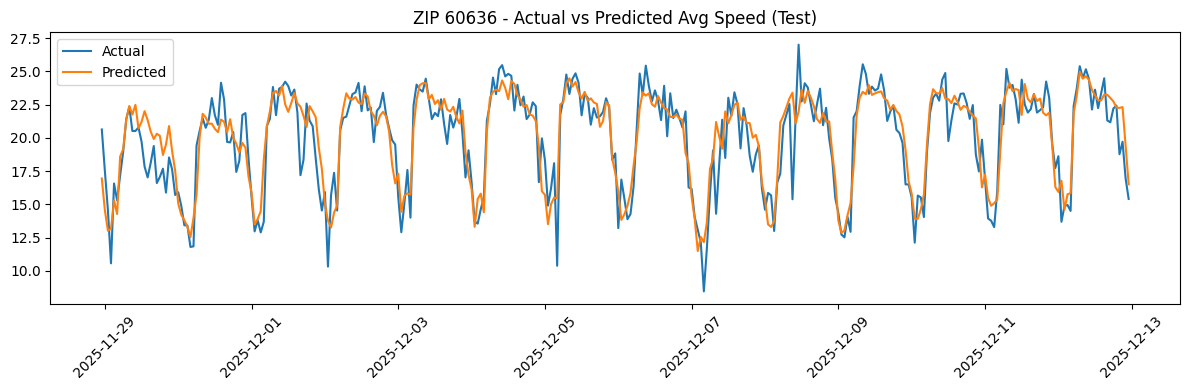

In [ ]:
sample_zip = test_df["zip"].value_counts().index[0]
sub = test_df[test_df["zip"] == sample_zip].copy()

if best_name == "CatBoost":
    sub_pred = best_model.predict(sub[feature_cols])
else:
    subX = one_hot(sub[feature_cols]).reindex(columns=one_hot(X_trainval).columns, fill_value=0)
    sub_pred = best_model.predict(subX)

sub = sub.sort_values("hour_ts")
plt.figure(figsize=(12,4))
plt.plot(sub["hour_ts"], sub[TARGET], label="Actual")
plt.plot(sub["hour_ts"], sub_pred, label="Predicted")
plt.title(f"ZIP {sample_zip} - Actual vs Predicted Avg Speed (Test)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
summary_path = REPORT_DIR / "model_results.txt"
with open(summary_path, "w") as f:
    f.write("UrbanSimAI Chicago - Speed Prediction Model\n")
    f.write(f"Saved at: {stamp()}\n\n")
    f.write(f"Best model: {best_name}\n")
    f.write(f"Final Test MAE: {final_mae:.4f}\n")
    f.write(f"Final Test RMSE: {final_rmse:.4f}\n\n")
    f.write("Data:\n")
    f.write(f"Train rows: {len(train_df)}\n")
    f.write(f"Val rows: {len(val_df)}\n")
    f.write(f"Test rows: {len(test_df)}\n")

print("✅ Saved:", summary_path)
print(open(summary_path).read())

✅ Saved: /content/drive/MyDrive/UrbanSimAI_Chicago/reports/model_results.txt
UrbanSimAI Chicago - Speed Prediction Model
Saved at: 2025-12-14 04:52:18 UTC

Best model: XGBoost
Final Test MAE: 1.1933
Final Test RMSE: 1.6675

Data:
Train rows: 81168
Val rows: 19152
Test rows: 19152



In [ ]:
#END